In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
FOLDERNAME = '682/assignment1'

import sys
# sys.path.append('content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.insert(0,'/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
%cd drive/MyDrive/682/assignment1/

/content/drive/MyDrive/682/assignment1


In [ ]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372900
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Since during weight matrix initialization, all weights are extremely small and so the calculation of loss with values close to 0 gives -log(0.1). This also intuitively makes sense, because in the beginning all classes are equally likely to be the correct class. So, probabilitty for a class is 1/10*


In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.665553 analytic: -4.665553, relative error: 1.039320e-08
numerical: -0.520011 analytic: -0.520011, relative error: 1.143970e-08
numerical: 1.200449 analytic: 1.200448, relative error: 1.123890e-07
numerical: 0.457597 analytic: 0.457597, relative error: 9.056176e-08
numerical: 0.311181 analytic: 0.311181, relative error: 8.428340e-09
numerical: 0.223462 analytic: 0.223462, relative error: 1.832257e-07
numerical: 2.076008 analytic: 2.076008, relative error: 1.278587e-08
numerical: -1.681721 analytic: -1.681721, relative error: 3.411707e-08
numerical: -2.128927 analytic: -2.128927, relative error: 7.492168e-09
numerical: 1.714930 analytic: 1.714930, relative error: 4.326020e-09
numerical: -0.252565 analytic: -0.252565, relative error: 3.289703e-08
numerical: -3.154095 analytic: -3.154095, relative error: 9.124653e-09
numerical: -0.699372 analytic: -0.699372, relative error: 4.097219e-08
numerical: 3.499242 analytic: 3.499242, relative error: 6.003281e-09
numerical: 1.833190 

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# # of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372900e+00 computed in 39.868112s
vectorized loss: 2.372900e+00 computed in 0.013015s
Loss difference: 0.000000
Gradient difference: 0.000000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax  #this comes from linear_classifier.py file
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-6, 2.5e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4 ]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
  for reg in regularization_strengths:
    clf = Softmax()
    clf.train(X_train, y_train, lr, reg, 1500, 100)
    
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    train_ac = np.mean(y_pred_train == y_train)
    val_ac = np.mean(y_pred_val == y_val)

    results[(lr, reg)] = (train_ac, val_ac)

    # saving the classifier if it has better accuracy till now
    if (val_ac > best_val):
      best_val = val_ac
      best_softmax = clf

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.336531 val accuracy: 0.352000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.326000 val accuracy: 0.339000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.316449 val accuracy: 0.330000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.318000 val accuracy: 0.337000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.312694 val accuracy: 0.326000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.305816 val accuracy: 0.324000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.310531 val accuracy: 0.318000
lr 2.000000e-06 reg 2.000000e+04 train accuracy: 0.296245 val accuracy: 0.308000
lr 2.000000e-06 reg 2.500000e+04 train accuracy: 0.304837 val accuracy: 0.305000
lr 2.000000e-06 reg 3.000000e+04 train accuracy: 0.279061 val accuracy: 0.293000
lr 2.000000e-06 reg 3.500000e+04 train accuracy: 0.266082 val accuracy: 0.276000
lr 2.000000e-06 reg 4.000000e+04 train accuracy: 0.252265 val accuracy: 0.264000
lr 2.000000e-06 reg 4.500000

In [19]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True (unless there is only one class in Softmax Classifier)

*Your explanation*: So to keep SVM loss unchanged, we can add a data point such that the result of summation(max(0, s_w - s_wy + 1) results in 0 or a data point that doesnt have a high score with any of the classes. But in case of Softmax Classifier, unless there is only one class, the numerator and denominator can never be equal in L = -log(correct class Probability/total Probability), hence it can never lead to a contribution of 0 loss.

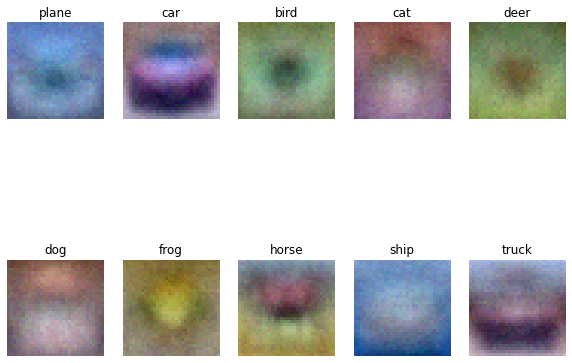

In [20]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])